In [1]:
### Importar librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from collections import Counter
from tqdm import tqdm

# Normalización
from sklearn.preprocessing import MinMaxScaler


# Métricas para Clasificación
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Input, Dense,  LSTM
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPool1D, Conv1D, Dropout, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix



## Cargamos los valores sin usar la API

In [149]:
df_trading_input = pd.read_csv(r".\data\inputs\df_trading_input.csv")

In [150]:
df_trading_input

,Volume,VIX_Close,Historical_Volatility,Alpha,Beta,date,Positive,Negative,Neutral,Financial_Sector_Close
0,22080200,13.68,14.021827,0.000733,1.075096,2020-02-14,0,0,0,31.170000
1,37768900,14.83,13.901178,0.001108,1.092396,2020-02-18,1,0,0,30.900000
2,25643300,14.38,14.055920,0.001325,1.093210,2020-02-19,1,0,0,31.129999
3,50344300,15.56,13.920540,0.000971,1.076815,2020-02-20,3,0,0,31.070000
4,51128200,17.08,14.111791,0.000615,1.058510,2020-02-21,2,0,0,30.770000
...,...,...,...,...,...,...,...,...,...,...
1086,31619000,12.74,11.564572,-0.008413,0.690060,2024-06-10,2,1,1,41.320000
1087,54584900,12.85,12.055650,-0.008239,0.719243,2024-06-11,0,0,0,40.849998
1088,46399800,12.04,11.688826,-0.008890,0.704915,2024-06-12,0,0,0,40.810001
1089,39497900,11.94,11.692790,-0.008362,0.725806,2024-06-13,0,0,0,40.779999


In [337]:
# Se toma el 90% de los datos para train. Se escala sobre ese 80%
datos = df_trading_input
len_train = int(0.9*len(datos))
datos = df_trading_input.drop(['date'], axis=1)

In [339]:
X = datos.drop('Financial_Sector_Close', axis=1)
y = datos['Financial_Sector_Close']

X_scaler = MinMaxScaler()
X_scaler.fit_transform(X[:len_train])
X_esc = X_scaler.transform(X)

y_scaler = MinMaxScaler()
y_ = np.array(y)
y_scaler.fit_transform(y_[:len_train].reshape(-1, 1))
y_esc = y_scaler.transform(y_.reshape(-1, 1))


# guardar scalers
with open('../models/y_scaler.pkl', 'wb') as f:
    pickle.dump(y_scaler, f) 
with open('../models/X_scaler.pkl', 'wb') as f:
    pickle.dump(X_scaler, f) 

In [340]:
scaler = MinMaxScaler()
scaler.fit_transform(datos[:len_train])
scaled_data = scaler.transform(datos)

datos = pd.DataFrame(scaled_data, columns=datos.columns)

with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f) 

In [309]:
df_trading_input.iloc[:, 5]

0       2020-02-14
1       2020-02-18
2       2020-02-19
3       2020-02-20
4       2020-02-21
           ...    
1086    2024-06-10
1087    2024-06-11
1088    2024-06-12
1089    2024-06-13
1090    2024-06-14
Name: date, Length: 1091, dtype: object

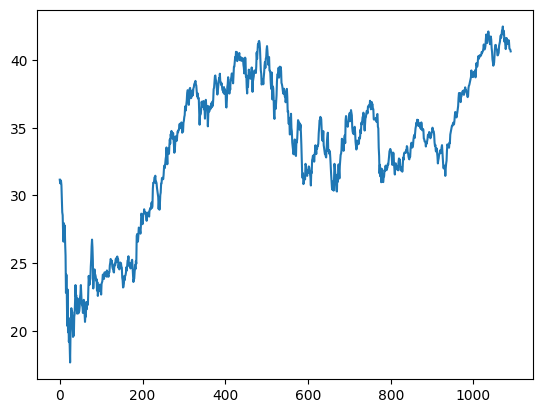

In [164]:
plt.plot(datos['Financial_Sector_Close'])
plt.show()

## Modelo

<!-- Modelos -->

In [326]:
T = 3 # Segmentos
X = list()
y = list()

for t in range(len(datos) - T):
    
    # Toma valores de X de t en t con stride de 1
    x = datos[t : t + T]
    X.append(x)
    
    # Toma los valores de t en t
    y_ = datos.iloc[t + T, -1]
    y.append(y_)

# Transformamos a np.array y ajustamos las dimensiones
# Para entrar en el modelo debe de tener 3 dimensiones
X = np.array(X).reshape(-1, T, datos.shape[1] ) ##  ndim = datos.shape[1]

y = np.array(y).reshape(-1, 1, 1 ) 

print(f"X: {X.shape}\ty: {y.shape}")

X: (1088, 3, 9)	y: (1088, 1, 1)


In [241]:
## Modelo
    
def trading():
    
    model = Sequential()

    model.add(Input(shape = (T, datos.shape[1]))) # T, 1) en lugar 1 sería ndim datos.shape[1]

    model.add(LSTM(units = 512, activation = "relu"))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1024, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(units = 256, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(units = 64, activation = "relu")) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 32, activation = "relu")) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 16, activation = "relu")) 

    model.add(Dense(units = 1))

    model.compile(optimizer = "adam", loss = "mse")
    return model
    

model = trading()
model.summary()

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_50 (LSTM)                  │ (None, 512)            │     1,069,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_135 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_136 (Dropout)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_137 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_138 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_139 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_196 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,875,841 (7.16 MB)

 Trainable params: 1,875,841 (7.16 MB)

 Non-trainable params: 0 (0.00 B)

In [242]:
# from keras.layers import Dense, LSTM, Dropout, Input
# from keras.regularizers import l2

In [243]:
# def trading():
#     model = Sequential()
    
#     model.add(Input(shape=(T, datos.shape[1])))  # T, datos.shape[1]
#     model.add(LSTM(units=512, activation='relu', return_sequences=True))
#     model.add(Dropout(0.2))
#     model.add(LSTM(units=256, activation='relu'))
#     model.add(Dropout(0.2))
    
#     model.add(Dense(units=256, activation='relu', kernel_regularizer=l2(0.1)))
#     model.add(Dropout(0.2))
#     model.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.1)))
#     model.add(Dropout(0.2))
#     model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.1)))
#     model.add(Dropout(0.2))
#     model.add(Dense(units=16, activation='relu', kernel_regularizer=l2(0.1)))
#     model.add(Dense(units=1))
    
#     model.compile(optimizer='adam', loss='mse')
#     return model

# model = trading()
# model.summary()

In [244]:
model = trading()

earlystopping = EarlyStopping(
    min_delta=0.000001, 
    patience=100
)
checkpoint = ModelCheckpoint(
    '../models/model_trading.keras', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    x = X[:len_train],
    y = y[:len_train],
    epochs = 1000,
    batch_size = 32,
    validation_data = (X[len_train:], y[len_train:]),
    verbose = 1
    ,callbacks = [checkpoint,earlystopping]
)

Epoch 1/1000


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3516
Epoch 1: val_loss improved from inf to 0.14537, saving model to model_tradding.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.3485 - val_loss: 0.1454
Epoch 2/1000
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0552
Epoch 2: val_loss improved from 0.14537 to 0.02188, saving model to model_tradding.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0546 - val_loss: 0.0219
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0306
Epoch 3: val_loss improved from 0.02188 to 0.00768, saving model to model_tradding.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0304 - val_loss: 0.0077
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0174
Epoch 4: val_loss did not improve from 0.00768
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0174 - val_loss: 0.0166
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0177
Epoch 5: val_loss improved from 0.00768 to 0.00291, saving model to

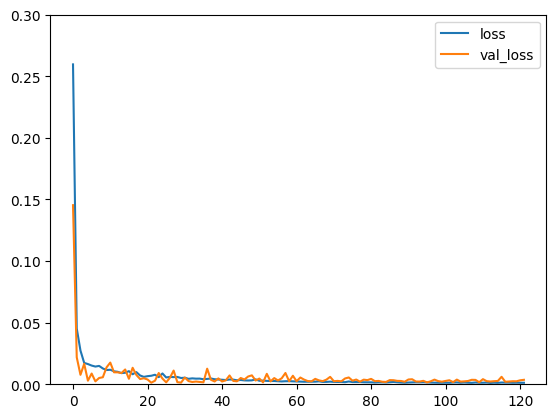

In [245]:
# loss
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend()
plt.ylim(0, 0.3)
plt.show()

In [308]:
type(df_trading_input.iloc[-1, 5])

str

In [288]:
# "1 - Step Predictions"

# Toma un valor y predice el siguiente

validation_target = y[len_train:]
validation_predictions = list()

i = len_train

while len(validation_predictions) < len(validation_target):
    
    # Predice el siguiente valor de X[i]
    # p = model.predict(X[i].reshape(1, -1, 1))[0] [:n_days_pred] 
    p = model.predict((X[i]).reshape(1, -1, datos.shape[1]))
    i += 1
    
    validation_predictions.append(p)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

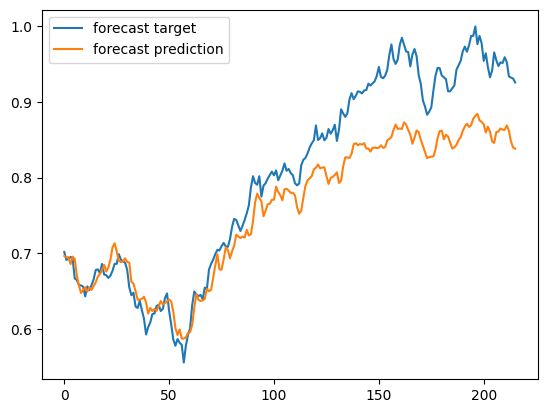

In [289]:
validation_predictions = np.array(validation_predictions)
#plt.plot(datos[920:],label = "datos")
plt.plot(validation_target.flatten(), label = "forecast target")
plt.plot(validation_predictions.flatten(), label = "forecast prediction")
# for i in range(validation_predictions.shape[1]):
#     plt.plot(validation_predictions[:, i], label=f"day {i+1} forecast prediction")
plt.legend()
plt.show()

In [341]:
validation_target_ = y_scaler.inverse_transform(validation_target.reshape(-1, 1))
validation_predictions_ = y_scaler.inverse_transform(validation_predictions.reshape(-1, 1))

In [342]:
import plotly.express as px

df_ = pd.DataFrame({
    'index': np.arange(len(validation_target_)),
    'forecast target': validation_target_.flatten(),
    'forecast prediction': validation_predictions_.flatten()
})

# Crear un gráfico de líneas con Plotly Express
fig = px.line(df_, x='index', y=['forecast target', 'forecast prediction'], 
              labels={'value': 'Value', 'index': 'Time'}, 
              title='Forecast vs Prediction',
              color_discrete_map={'forecast target': 'red', 'forecast prediction': 'blue'})

# Mostrar el gráfico
fig.show()


In [286]:
# a=np.array(df_trading_input['Financial_Sector_Close'][:len_train])
# scaler.fit_transform(a.reshape(-1, 1))
y_pred = y_scaler.inverse_transform(validation_predictions.reshape(-1, 1))
y_pred
# guardar resultado modelo
with open('y_scaler.pkl', 'wb') as f:
    pickle.dump(y_scaler, f) 

array([[30.182152],
       [30.136871],
       [29.97208 ],
       [29.271044],
       [28.519878],
       [27.87345 ],
       [26.659899],
       [26.30091 ],
       [26.487158],
       [26.912584],
       [26.247377],
       [25.567913],
       [24.986673],
       [24.317001],
       [23.992619],
       [23.583366],
       [22.95123 ],
       [22.858057],
       [22.202894],
       [21.951849],
       [21.530853],
       [21.659552],
       [21.794357],
       [21.839687],
       [22.235138],
       [22.515734],
       [22.807497],
       [22.688929],
       [22.675816],
       [22.632364],
       [22.474098],
       [22.509794],
       [22.543713],
       [22.824192],
       [23.006144],
       [23.269697],
       [23.683397],
       [23.820004],
       [23.84991 ],
       [23.601381],
       [23.457273],
       [23.563635],
       [23.53564 ],
       [23.38084 ],
       [23.284657],
       [23.28248 ],
       [23.370546],
       [23.68122 ],
       [23.82134 ],
       [23.930405],


In [160]:
X[len_train][-1][datos.shape[1]-1]

0.6298831347683437

In [343]:
# "Multiple - Step Predictions"

# Toma el último valor de una serie y predice el siguiente
# Usa esa predicción para seguir haciendo predicciones.
n_days_pred=100  #ELIMINAR este valor se definirá arriba
validation_target = y[len_train:]
validation_predictions = list()
last_x = X[len_train]

for i in range(n_days_pred):
    if len(validation_predictions) < len(validation_target):
    
        # En la primera iteración predice el siguiente valor de usando X
        # En las siguientes iteraciones usa el valor predicho anterior para predecir el siguiente
        # p = model.predict(last_x.reshape(1, -1, 1))[0, 0]
        p = model.predict((X[i]).reshape(1, -1, datos.shape[1]))[0, 0]
        validation_predictions.append(p)
        valor_target = last_x[-1][datos.shape[1]-1]
      
        print(f"Valor: {valor_target}\tPredicción: {p}")
        # Desplaza los elementos en last_x hacia atrás (en esta caso desplazamos toda la fila), dejando el primer elemento al final
        last_x = np.roll(last_x, -1, axis=0)
        
        # Cambia el último elemento a la predicción
        # en este caso se cambia solo el valor a predecir y se mantienen invariables los últimos valores de los demás parámetros
        # estos valores (análisis de sentiniento, VIX, alpha, beta...) serán los del último día conocido e iguales para los n_days_pred de la predicción
        last_x[-1][datos.shape[1]-1] = p

KeyError: 981

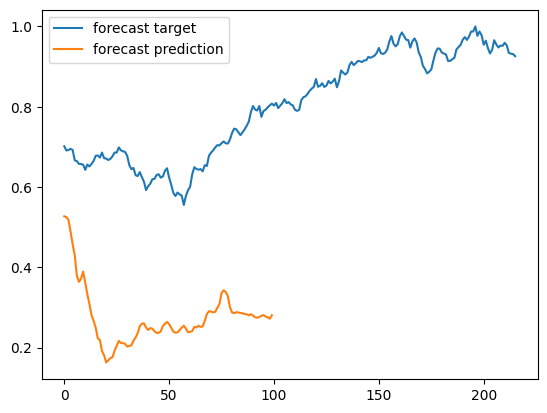

In [254]:
plt.plot(validation_target.flatten(), label = "forecast target")

plt.plot(validation_predictions, label = "forecast prediction")
plt.legend()
plt.show()

In [ ]:
# guardar resultado modelo
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f) 

In [ ]:
# cargar resultado modelo
with open('history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

In [295]:
# # Ruta del archivo del modelo guardado
# Cargar el modelo guardado
model = load_model('model_trading.keras', compile=False)
model.compile(optimizer = "adam", loss = "mse")
# Mostrar el resumen del modelo para verificar que se cargó correctamente
model.summary()


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_51 (LSTM)                  │ (None, 512)            │     1,069,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_140 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_141 (Dropout)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_142 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_143 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_144 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,875,841 (7.16 MB)

 Trainable params: 1,875,841 (7.16 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
confusion_matrix(y_test, ypred)

array([[ 64,  37,  47],
       [ 40, 587,  93],
       [ 25, 107, 331]], dtype=int64)